# Week 6_Day 4: Improving CIFAR-10 CNN

### Dataset, Transforms and Dataloader(for improved CNN)

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset

# Transform: turn image into tensor
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# Load full training set
full_train_aug = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform_train
)

full_train_clean = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform_test
)

# Split into train/val
train_size = int(0.9 * len(full_train_aug))
val_size = len(full_train_aug) - train_size

train_split, val_split = random_split(full_train_aug, [train_size, val_size])

train_ds = Subset(full_train_aug, train_split.indices)
val_ds   = Subset(full_train_clean, val_split.indices)

# Test set (separate)
test_ds = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform_test
)

# DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

### Setup: Model, Loss, Optimizer, Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # conv layer1
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=32,
            kernel_size=3, 
            padding=1
        )
        # batch normalization 1
        self.bn1   = nn.BatchNorm2d(32)

        # conv layer2
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            padding=1
        )
        # batch normalization 2
        self.bn2   = nn.BatchNorm2d(64)

        # pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # fc layers
        self.fc1 = nn.Linear(64*8*8, 256)
        self.dropout = nn.Dropout(0.1)  # dropout
        self.fc2 = nn.Linear(256, 10)

    def forward(self,x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))

        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [4]:
model = SimpleCNN().to(device)

In [5]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

### Training Loop

In [6]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()  # enables training behavior 

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [7]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()  # disables training behavior

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

### Run Training for Multiple Epochs + Track Curves

In [8]:
import matplotlib.pyplot as plt

EPOCHS = 30

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f} | "
          f"Val Loss: {va_loss:.4f}, Val Acc: {va_acc:.4f}")

Epoch 1/30 | Train Loss: 1.8743, Train Acc: 0.3246 | Val Loss: 1.4528, Val Acc: 0.4464
Epoch 2/30 | Train Loss: 1.5209, Train Acc: 0.4360 | Val Loss: 1.3131, Val Acc: 0.5280
Epoch 3/30 | Train Loss: 1.3781, Train Acc: 0.4974 | Val Loss: 1.1766, Val Acc: 0.5850
Epoch 4/30 | Train Loss: 1.3062, Train Acc: 0.5262 | Val Loss: 1.0868, Val Acc: 0.6230
Epoch 5/30 | Train Loss: 1.2501, Train Acc: 0.5502 | Val Loss: 1.0461, Val Acc: 0.6340
Epoch 6/30 | Train Loss: 1.2154, Train Acc: 0.5644 | Val Loss: 0.9973, Val Acc: 0.6560
Epoch 7/30 | Train Loss: 1.1819, Train Acc: 0.5753 | Val Loss: 1.0068, Val Acc: 0.6560
Epoch 8/30 | Train Loss: 1.1580, Train Acc: 0.5825 | Val Loss: 0.9765, Val Acc: 0.6652
Epoch 9/30 | Train Loss: 1.1369, Train Acc: 0.5940 | Val Loss: 0.9251, Val Acc: 0.6746
Epoch 10/30 | Train Loss: 1.1273, Train Acc: 0.5978 | Val Loss: 0.9223, Val Acc: 0.6856
Epoch 11/30 | Train Loss: 1.1008, Train Acc: 0.6057 | Val Loss: 0.8914, Val Acc: 0.7006
Epoch 12/30 | Train Loss: 1.0835, Train A

### Plot Training Curves

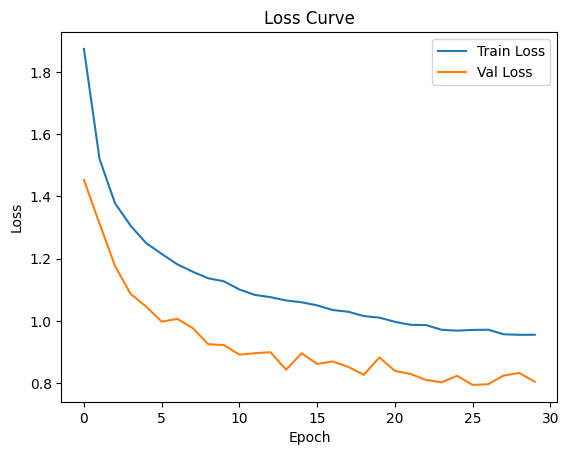

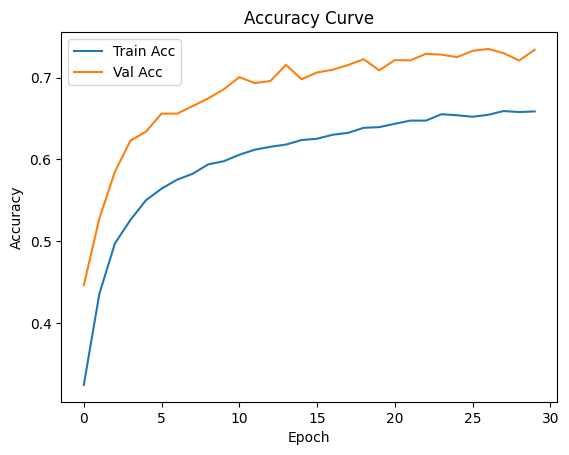

In [9]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure()
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

Training phase is done here. 

---
___

# Week 6_Day 5: Evaluation & Analysis

### Evaluation 

**Final Test Evaluation**

In [10]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Test Loss: 0.7986 | Test Acc: 0.7228


**Collect Predictions**

In [11]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

### Analysis

**Confusion Matrix**

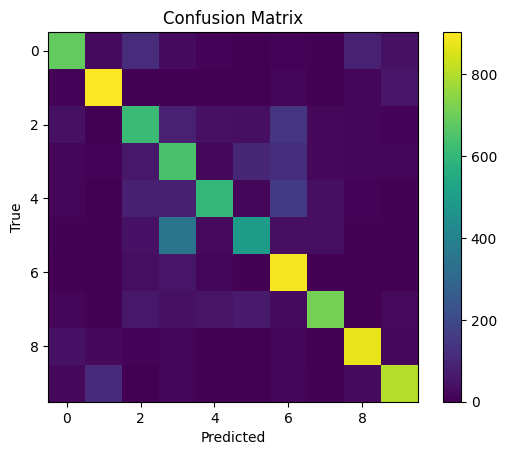

In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

**Classification Report**

In [14]:
from sklearn.metrics import classification_report

class_names = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.81      0.69      0.74      1000
  automobile       0.84      0.90      0.87      1000
        bird       0.61      0.62      0.61      1000
         cat       0.49      0.64      0.56      1000
        deer       0.79      0.60      0.69      1000
         dog       0.69      0.50      0.58      1000
        frog       0.63      0.89      0.74      1000
       horse       0.85      0.72      0.78      1000
        ship       0.84      0.87      0.85      1000
       truck       0.83      0.80      0.81      1000

    accuracy                           0.72     10000
   macro avg       0.74      0.72      0.72     10000
weighted avg       0.74      0.72      0.72     10000



**Error Analysis**

In [15]:
# shoeing a grid of wrong predictions
wrong_idx = (all_preds != all_labels).nonzero().squeeze()

# take first 12 wrong examples
sample_wrong = wrong_idx[:12]

In [16]:
# saving the model
torch.save(model.state_dict(), "cifar10_cnn.pth")